In [1]:
import types
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
# PyTorch
import torch
import torchvision
import torchmetrics

In [2]:
import sys
sys.path.append('../src/')

%load_ext autoreload
%autoreload 2
# Importing our custom module(s)
import losses
import utils

In [3]:
dataset_directory = '/cluster/tufts/hugheslab/eharve06/CIFAR-10'
n = 1000
tune = False
random_state = 1001
augmented_train_dataset, train_dataset, val_or_test_dataset = utils.get_cifar10_datasets(dataset_directory, n, tune, random_state)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
batch_size = 128
num_workers = 0
augmented_train_loader = torch.utils.data.DataLoader(augmented_train_dataset, batch_size=min(batch_size, len(augmented_train_dataset)), shuffle=True, num_workers=num_workers, drop_last=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=min(batch_size, len(train_dataset)), num_workers=num_workers)
val_or_test_loader = torch.utils.data.DataLoader(val_or_test_dataset, batch_size=batch_size, num_workers=num_workers)

In [58]:
num_classes = 10
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

model = torchvision.models.resnet50()
model.fc = torch.nn.Linear(in_features=2048, out_features=num_classes, bias=True)
model.sigma_param = torch.nn.Parameter(torch.log(torch.expm1(torch.tensor(1e-4, device=device))))
utils.add_variational_layers(model, model.sigma_param)
model.use_posterior = types.MethodType(utils.use_posterior, model)
model.to(device)

bb_loc = torch.load('/cluster/tufts/hugheslab/eharve06/resnet50_torchvision/resnet50_torchvision_mean.pt', map_location=torch.device('cpu')).to(device)
criterion = losses.ERMLoss()

cuda:0


In [64]:
import matplotlib.pyplot as plt

# Get the first 10 default colors from the color cycle
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
print("First 10 default Matplotlib colors:")
for i, color in enumerate(colors[:10]):
    print(f"{i + 1}: {color}")


First 10 default Matplotlib colors:
1: #1f77b4
2: #ff7f0e
3: #2ca02c
4: #d62728
5: #9467bd
6: #8c564b
7: #e377c2
8: #7f7f7f
9: #bcbd22
10: #17becf


In [62]:
checkpoint = torch.load('/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/retrained_CIFAR-10_VI/l2-sp_kappa=23528.522_lr_0=0.01_n=1000_random_state=1001.pt', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint)
model.to(device)

val_or_test_metrics = utils.evaluate(model, criterion, val_or_test_loader, num_classes=num_classes)
print(val_or_test_metrics['acc'])
print(val_or_test_metrics['nll'])

0.4535424769401549


In [63]:
labels = torch.stack(val_or_test_metrics['labels'])
logits = torch.stack(val_or_test_metrics['logits'])
probas = torch.softmax(logits, dim=-1)
ece = torchmetrics.classification.MulticlassCalibrationError(num_classes=num_classes, n_bins=30, norm='l1')
print(ece(logits, labels).item())

0.06309692561626434


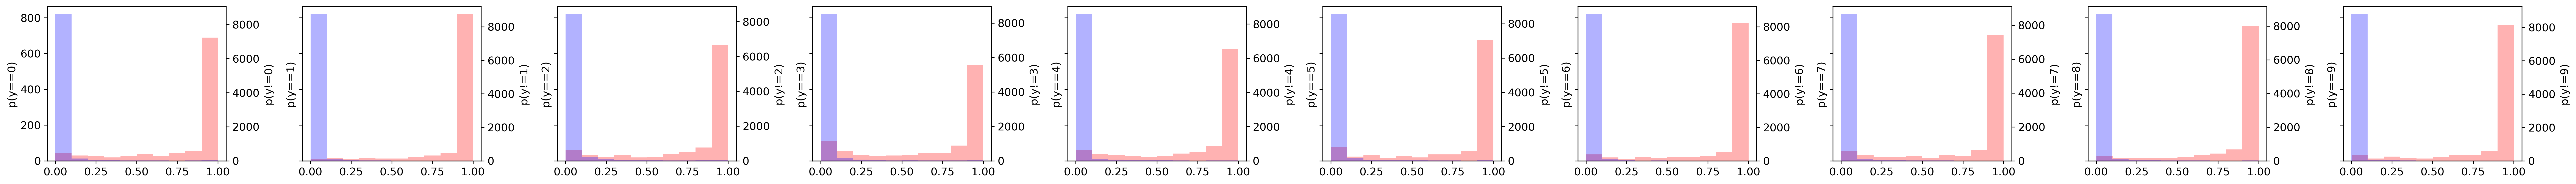

In [61]:
ncols, nrows = 10, 1

fig, axs = plt.subplots(figsize=(4*ncols, 3*nrows), dpi=300, ncols=ncols, nrows=nrows, sharey=True)
twin_axs = np.empty_like(axs)

for i in range(10):
    axs[i].hist(probas[:,i][labels==i], alpha=0.3, color='red')
    axs[i].set_ylabel(f'p(y=={i})')
    twin_axs[i] = axs[i].twinx()
    twin_axs[i].hist(probas[:,i][labels!=i], alpha=0.3, color='blue')
    twin_axs[i].set_ylabel(f'p(y!={i})')
    
fig.tight_layout()
plt.show()

In [54]:
model = torchvision.models.resnet50()
model.fc = torch.nn.Linear(in_features=2048, out_features=num_classes, bias=True)

criterion = losses.ERMLoss()

In [55]:
checkpoint = torch.load('/cluster/tufts/hugheslab/eharve06/data-emphasized-ELBo/experiments/retrained_CIFAR-10/l2-sp_alpha=0.001_beta=0.0001_lr_0=0.1_n=1000_random_state=1001.pt', map_location=torch.device('cpu'))
model.load_state_dict(checkpoint)
model.to(device)

val_or_test_metrics = utils.evaluate(model, criterion, val_or_test_loader, num_classes=num_classes)
print(val_or_test_metrics['acc'])
print(val_or_test_metrics['nll'])

0.4106845069885254


In [56]:
labels = torch.stack(val_or_test_metrics['labels'])
logits = torch.stack(val_or_test_metrics['logits'])
probas = torch.softmax(logits, dim=-1)
ece = torchmetrics.classification.MulticlassCalibrationError(num_classes=num_classes, n_bins=30, norm='l1')
print(ece(logits, labels).item())

0.058140020817518234


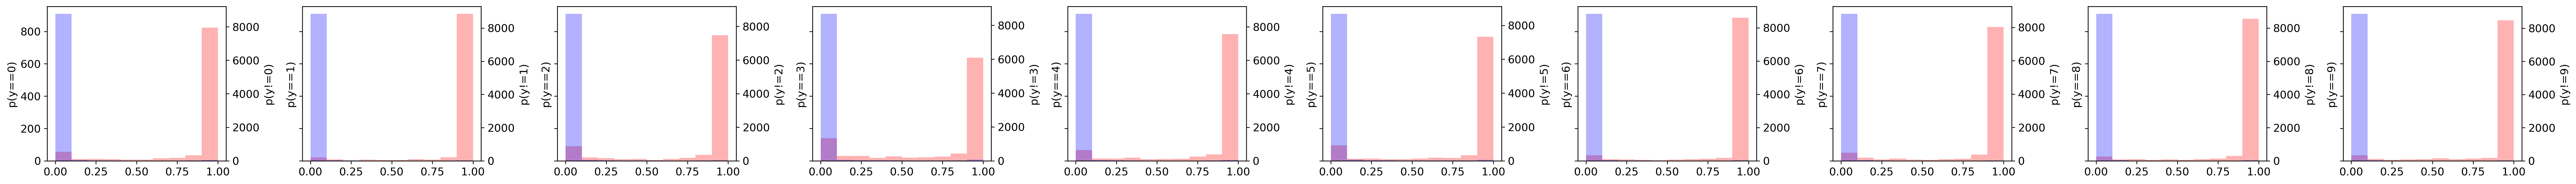

In [57]:
ncols, nrows = 10, 1

fig, axs = plt.subplots(figsize=(4*ncols, 3*nrows), dpi=300, ncols=ncols, nrows=nrows, sharey=True)
twin_axs = np.empty_like(axs)

for i in range(10):
    axs[i].hist(probas[:,i][labels==i], alpha=0.3, color='red')
    axs[i].set_ylabel(f'p(y=={i})')
    twin_axs[i] = axs[i].twinx()
    twin_axs[i].hist(probas[:,i][labels!=i], alpha=0.3, color='blue')
    twin_axs[i].set_ylabel(f'p(y!={i})')
    
fig.tight_layout()
plt.show()